# COX Proportional Hazards Model for Islet Autoantibody Outcome  
>
This notebook contains the code for generating supplementary figures 3 and 4.  

For the main analysis, tri-SNP dosage (0, 1 or 2) is fitted along with covariates: sex, having a first degree relative with T1D diagnosis, genetic ancestry, HLA type, country and SNPS previously associated with the outcome.

In addition, the extended haplotype DR3-B8 is fitted instead of tri-SNP as a comparison to show the affect of tri-snp is stronger. 

The analyses are repeated using only DR3/DQ2 homozygotes.

This notebook is not heavily commented. Please see the code notebook for supplementary figures 1 and 2 for the comments and detailed explanation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from lifelines import CoxPHFitter
import pickle
import warnings
warnings.filterwarnings("ignore")
import session_info

session_info.show(html=False)

-----
lifelines           0.26.3
matplotlib          3.9.4
pandas              1.5.3
session_info        1.0.0
-----
IPython             8.18.1
jupyter_client      8.6.3
jupyter_core        5.8.1
jupyterlab          4.4.5
notebook            7.4.5
-----
Python 3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:27:35) [Clang 11.1.0 ]
macOS-15.6.1-x86_64-i386-64bit
-----
Session information updated at 2025-09-19 09:50


Import metadata

In [3]:
filtered = pd.read_csv("../data/filtered_meta_final.csv")
filtered.head()

,mp257_maskid,family_id,immunochip_id,sex,Cntry,POP,ancestry,POP_reported,t1d,t1d_diag_age_censor,...,rs61751041 (LAMB1),rs6967298 (AUTS2),rs72704176 (ASH1L),rs72717025 (FCGR2A),rs73043122 (RNASET2/MIR3939),rs77532435 (GRB10),rs8013918 (FOS),rs9934817 (RBFOX1),rs389884,rs926552
0,996512,9000247.0,9000247_996512,Male,SWE,EUR,EUR,NaN,1,135.972,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,474979,474979.0,474979_474979,Male,SWE,EUR,EUR,NaN,0,183.443,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2,581412,581412.0,581412_581412,Male,SWE,EUR,EUR,NaN,0,186.235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,864158,864158.0,864158_864158,Male,SWE,EUR,EUR,EUR,0,167.017,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,669152,669152.0,669152_669152,Male,SWE,EUR,EUR,NaN,0,174.080,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0


Create ordered hla type list

In [4]:
select_hla = ['DR4/DR8', 'DR3/DR3', 'DR3/DR4',
              'DR4/DR4', "DR1/DR4", "DR4/DR13"]
filtered["hla_type"] = pd.Categorical(filtered["hla_type"], 
               categories=select_hla,
               ordered=True)

Create oredered population list

In [5]:
select_pops = ["EUR", "AMR", "AFR"]
filtered["POP"] = pd.Categorical(
    filtered["POP"],
    categories=select_pops,
    ordered=True)

Create ordered country category

In [6]:
ctry = ["US", "SWE", "FIN", "GER"]
filtered["Country"] = pd.Categorical(
    filtered["Cntry"],
    categories=ctry,
    ordered=True)

Load previous GWAS covariates

In [7]:
snps = pd.read_table("../data/assoc_snps_220824.tsv")
snps.head()

,SNP,Locus,CD_SNP,tTGA_SNP,T1D_SNP,IAA_SNP,SNP_locus
0,rs4851575,"IL18R1, IL18RAP",1,0,0,0,"rs4851575 (IL18R1, IL18RAP)"
1,rs114569351,"PLEK,FBXO48",1,0,0,0,"rs114569351 (PLEK,FBXO48)"
2,rs12493471,"CCR9,LZTFL1,CXCR6",1,0,0,0,"rs12493471 (CCR9,LZTFL1,CXCR6)"
3,rs1054091,"RSPH3,TAGAP",1,0,0,0,"rs1054091 (RSPH3,TAGAP)"
4,rs72704176,ASH1L,1,0,0,0,rs72704176 (ASH1L)


In [8]:
t1d_snps = list(snps.loc[snps["T1D_SNP"] == 1, "SNP_locus"].values)
iaa_snps = list(snps.loc[snps["IAA_SNP"] == 1, "SNP_locus"].values)
tga_snps = list(snps.loc[snps["tTGA_SNP"] == 1, "SNP_locus"].values)
cd_snps = list(snps.loc[snps["CD_SNP"] == 1, "SNP_locus"].values)

## Run coxph model for islet autoantibody status

In [9]:
assoc = iaa_snps
event = "Event = Islet Autoantibody"
common_variables = ['sex', 'FDR-T1D', 'POP', "hla_type", 
                    "Country"] + assoc


common_others = ["Male", 'FDR-T1D']

time, outcome = "persist_conf_ab_censor", "persist_conf_ab"
outcomes = [time, outcome]

### Fit trisnp
This creates supplementary figure 3.

<lifelines.CoxPHFitter: fitted with 7614 total observations, 6759 right-censored observations>
             duration col = 'persist_conf_ab_censor'
                event col = 'persist_conf_ab'
          robust variance = True
      baseline estimation = breslow
   number of observations = 7614
number of events observed = 855
   partial log-likelihood = -7247.47
         time fit was run = 2025-09-19 13:51:38 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
tri-SNP 101            -0.34       0.71       0.10            -0.55            -0.14                 0.58                 0.87
FDR-T1D                 0.77       2.16       0.10             0.58             0.96                 1.78                 2.62
rs428595 (PPIL2)        0.69       2.00       0.10             0.49             0.89                 1.63                 2.44
rs1004446 (INS)        -0.18       0.84       0.05            -0.28            -0.08                 0.76                 0.92
rs2476601 (PTPN22)      0.32       1.38       0.07             0.19             0.45                 1.22                 1.57
rs2292239 (ERBB3)       0.17       1.19       0.05             0.08             0.27                 1.08                 1.31
rs3184504 (SH2B3)       0.24       1.27       0.05             0.14             0.33                 1.15                 1.39
rs9934817 (RBFOX1)      0.38       1.46       0.16             0.07             0.69                 1.07                 1.99
rs11705721 (PXK/PDHB)   0.16       1.18       0.05             0.06             0.26                 1.06                 1.30
Male                    0.17       1.19       0.07             0.04             0.31                 1.04                 1.36
AMR                    -0.07       0.93       0.15            -0.35             0.22                 0.70                 1.24
AFR                     0.10       1.11       0.42            -0.72             0.92                 0.49                 2.52
DR3/DR3                 0.29       1.33       0.22            -0.14             0.72                 0.87                 2.05
DR3/DR4                 0.61       1.83       0.13             0.34             0.87                 1.41                 2.39
DR4/DR4                 0.04       1.04       0.12            -0.20             0.27                 0.82                 1.31
DR1/DR4                -0.61       0.54       0.27            -1.14            -0.08                 0.32                 0.92
DR4/DR13               -0.04       0.96       0.35            -0.73             0.64                 0.48                 1.90
SWE                     0.22       1.25       0.09             0.06             0.39                 1.06                 1.48
FIN                     0.30       1.34       0.10             0.11             0.49                 1.11                 1.63
GER                    -0.01       0.99       0.15            -0.32             0.29                 0.73                 1.33

                          z      p   -log2(p)
covariate                                    
tri-SNP 101           -3.27 <0.005       9.87
FDR-T1D                7.81 <0.005      47.30
rs428595 (PPIL2)       6.70 <0.005      35.44
rs1004446 (INS)       -3.48 <0.005      10.97
rs2476601 (PTPN22)     4.93 <0.005      20.24
rs2292239 (ERBB3)      3.50 <0.005      11.08
rs3184504 (SH2B3)      4.77 <0.005      19.04
rs9934817 (RBFOX1)     2.37   0.02       5.82
rs11705721 (PXK/PDHB)  3.19 <0.005       9.46
Male                   2.48   0.01       6.25
AMR                   -0.46   0.64       0.64
AFR                    0.25   0.81       0.31
DR3/DR3                1.31   0.19       2.39
DR3/DR4                4.50 <0.005      17.13
DR4/DR4                0.32   0.75       0.42
D

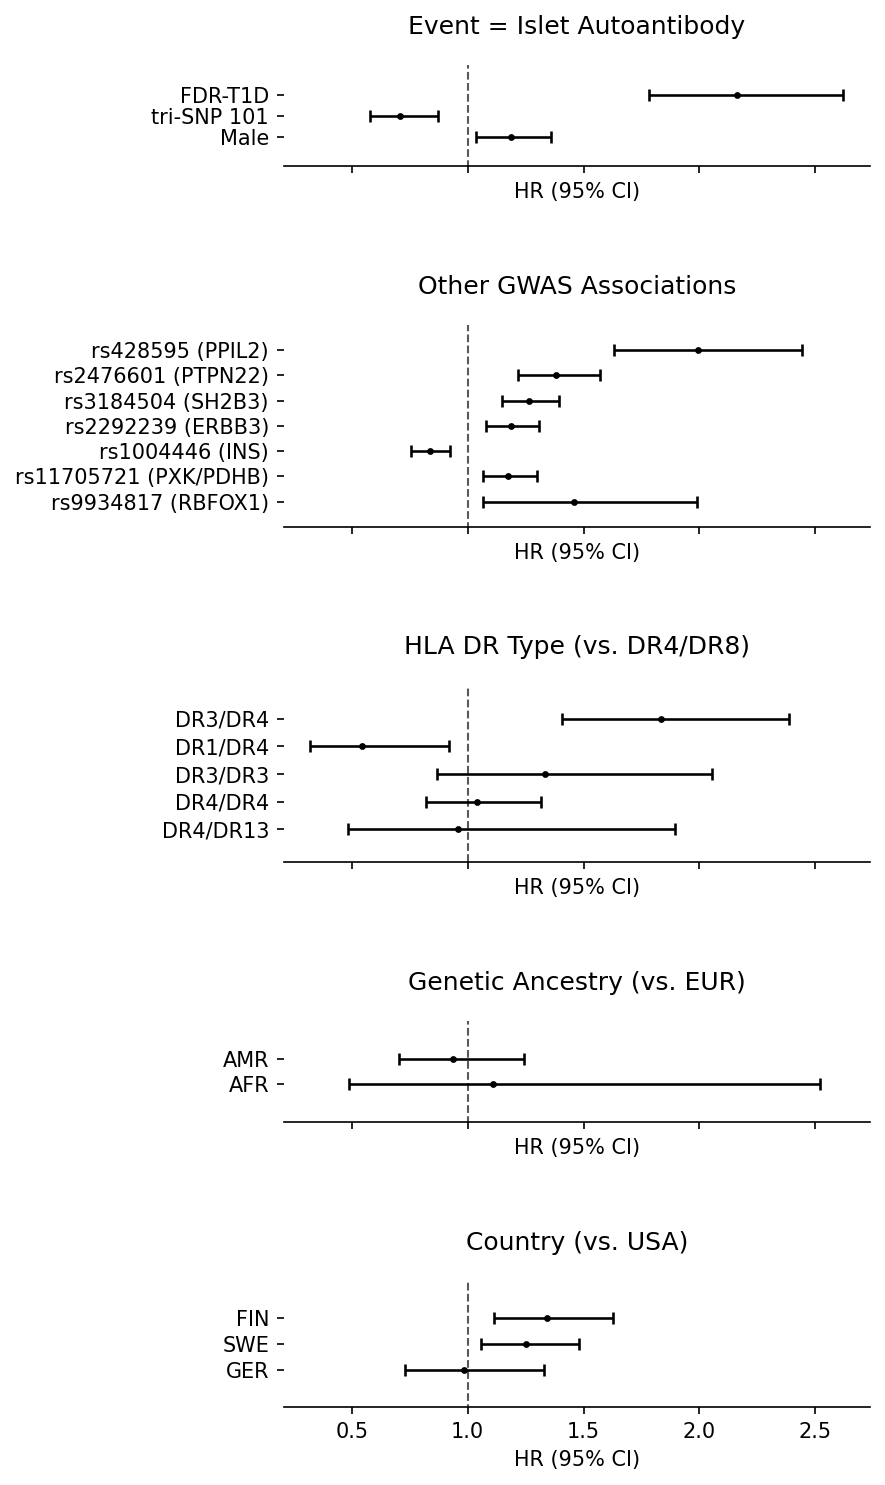

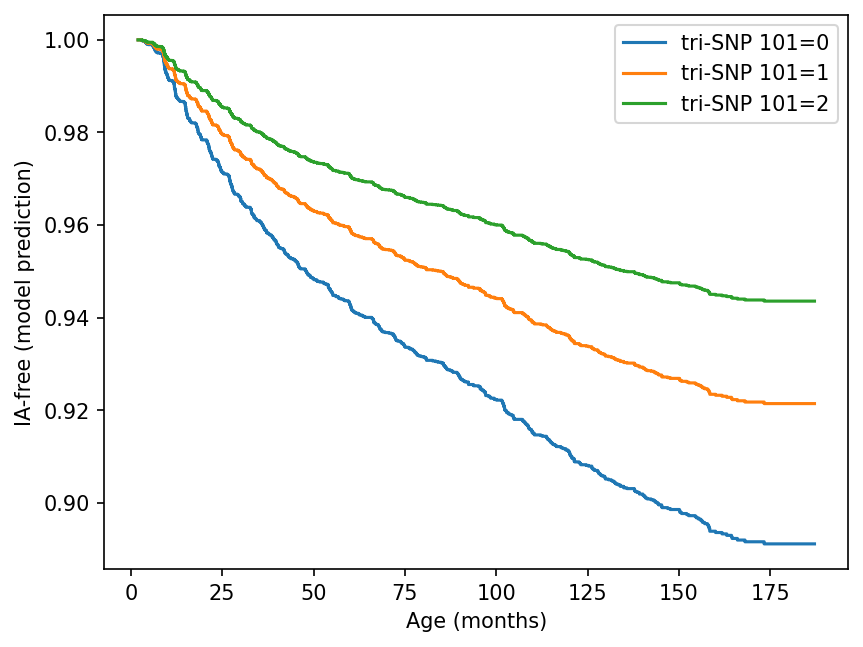

In [10]:
fit_var = "tri-SNP 101"

extension = "cox_ia_all_samples"
ylabel = "IA-free (model prediction)"

variables = [fit_var] + common_variables
data = filtered.loc[:, variables + outcomes].dropna()
dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_hla, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "HLA DR Type (vs. DR4/DR8)", 
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=True, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)

### Fit B8 for all samples
Change the variable fitted from tri-SNP to DR3-B8. This figure is not used in the paper but the model output is used in the text.

<lifelines.CoxPHFitter: fitted with 7614 total observations, 6759 right-censored observations>
             duration col = 'persist_conf_ab_censor'
                event col = 'persist_conf_ab'
          robust variance = True
      baseline estimation = breslow
   number of observations = 7614
number of events observed = 855
   partial log-likelihood = -7247.93
         time fit was run = 2025-09-19 13:51:45 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
B8                     -0.23       0.80       0.07            -0.37            -0.08                 0.69                 0.92
FDR-T1D                 0.77       2.16       0.10             0.58             0.96                 1.78                 2.62
rs428595 (PPIL2)        0.68       1.98       0.11             0.48             0.89                 1.61                 2.44
rs1004446 (INS)        -0.18       0.84       0.05            -0.28            -0.08                 0.76                 0.92
rs2476601 (PTPN22)      0.32       1.38       0.07             0.20             0.45                 1.22                 1.57
rs2292239 (ERBB3)       0.17       1.18       0.05             0.07             0.27                 1.07                 1.30
rs3184504 (SH2B3)       0.24       1.27       0.05             0.14             0.33                 1.15                 1.39
rs9934817 (RBFOX1)      0.37       1.44       0.16             0.06             0.68                 1.06                 1.97
rs11705721 (PXK/PDHB)   0.16       1.18       0.05             0.06             0.26                 1.06                 1.30
Male                    0.17       1.19       0.07             0.03             0.31                 1.04                 1.36
AMR                    -0.05       0.95       0.14            -0.33             0.24                 0.72                 1.27
AFR                     0.23       1.26       0.42            -0.58             1.05                 0.56                 2.85
DR3/DR3                -0.02       0.98       0.16            -0.33             0.29                 0.72                 1.33
DR3/DR4                 0.45       1.56       0.11             0.23             0.67                 1.26                 1.95
DR4/DR4                 0.03       1.04       0.12            -0.20             0.27                 0.82                 1.31
DR1/DR4                -0.61       0.54       0.27            -1.14            -0.08                 0.32                 0.92
DR4/DR13               -0.05       0.95       0.35            -0.73             0.64                 0.48                 1.89
SWE                     0.22       1.25       0.09             0.05             0.39                 1.05                 1.48
FIN                     0.28       1.33       0.10             0.09             0.47                 1.10                 1.60
GER                    -0.02       0.98       0.15            -0.32             0.28                 0.73                 1.33

                          z      p   -log2(p)
covariate                                    
B8                    -3.03 <0.005       8.69
FDR-T1D                7.83 <0.005      47.57
rs428595 (PPIL2)       6.47 <0.005      33.27
rs1004446 (INS)       -3.49 <0.005      11.02
rs2476601 (PTPN22)     4.95 <0.005      20.36
rs2292239 (ERBB3)      3.43 <0.005      10.70
rs3184504 (SH2B3)      4.76 <0.005      18.99
rs9934817 (RBFOX1)     2.31   0.02       5.58
rs11705721 (PXK/PDHB)  3.20 <0.005       9.51
Male                   2.46   0.01       6.18
AMR                   -0.33   0.74       0.44
AFR                    0.56   0.58       0.80
DR3/DR3               -0.13   0.90       0.16
DR3/DR4                4.03 <0.005      14.13
DR4/DR4                0.29   0.77       0.37
D

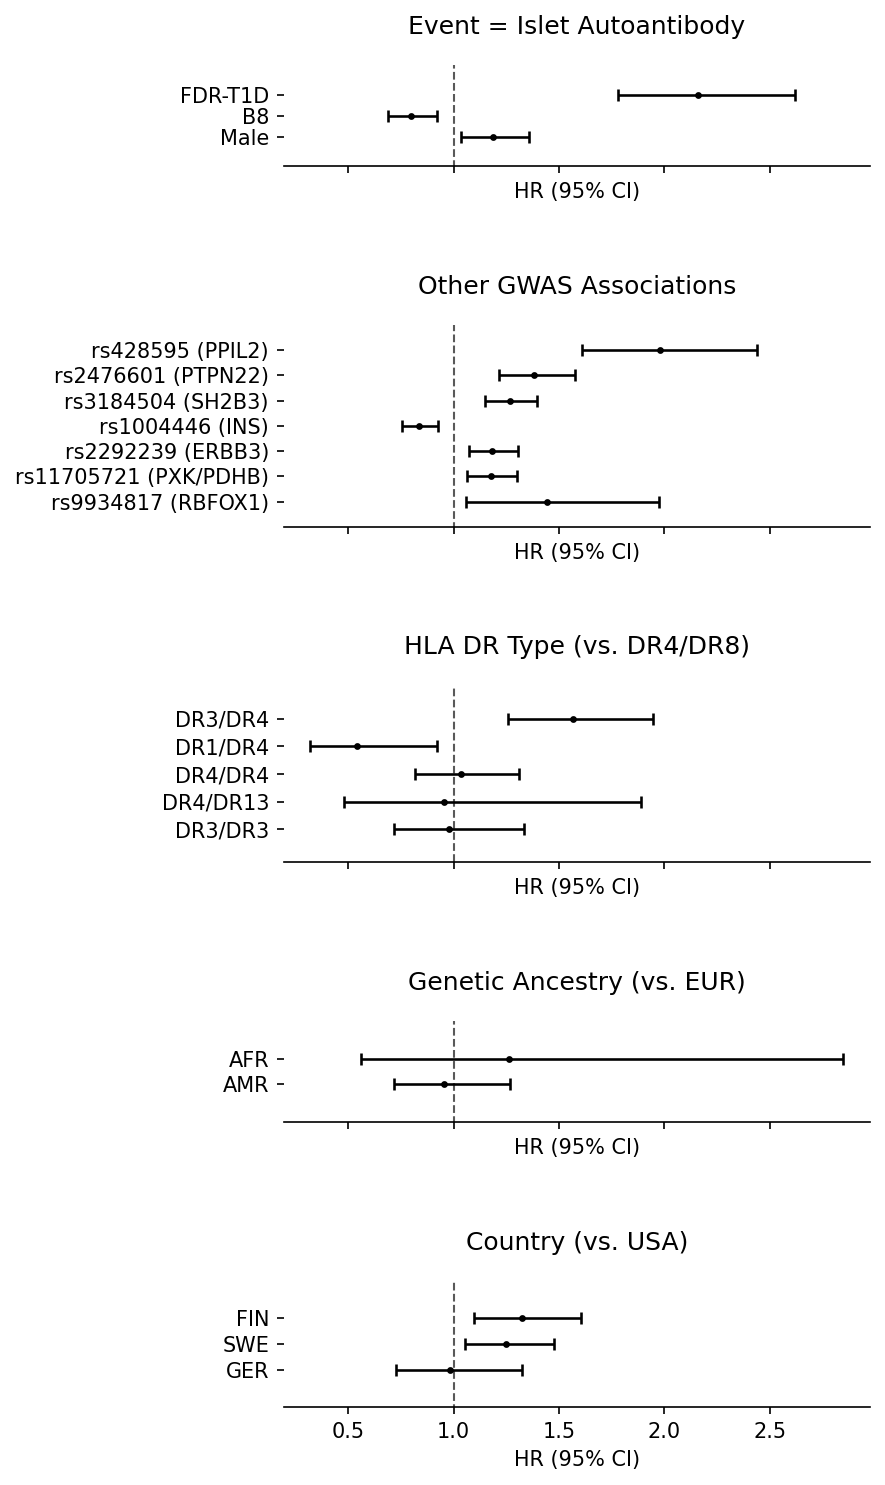

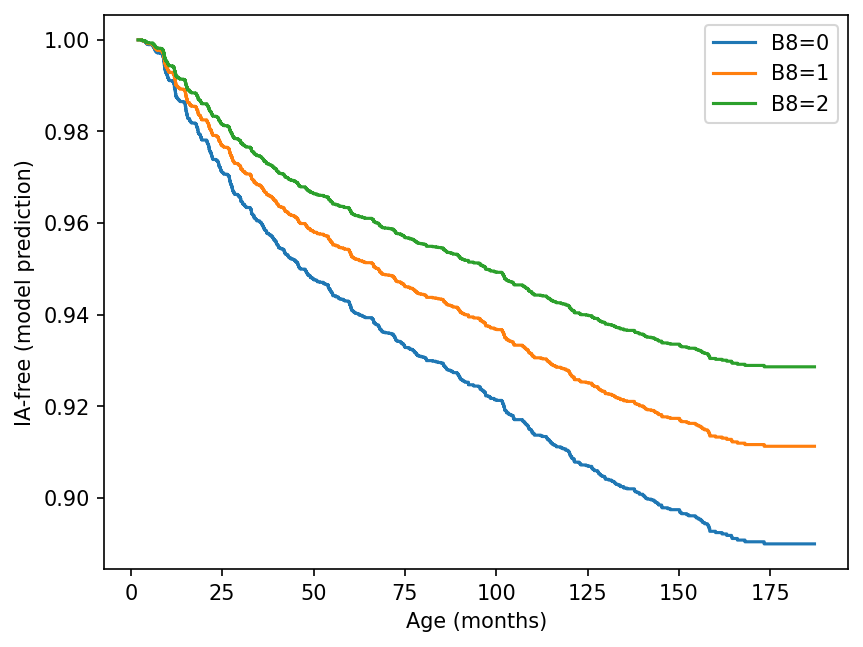

In [11]:
fit_var = "B8"

extension = "cox_ia_all_samples_b8"
ylabel = "IA-free (model prediction)"

variables = [fit_var] + common_variables
data = filtered.loc[:, variables + outcomes].dropna()
dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_hla, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "HLA DR Type (vs. DR4/DR8)", 
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=True, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)

### DR3 homozygotes only

In [12]:
event = "Event = Islet Autoantibody, DR3 Only"

common_variables = ['sex', 'FDR-T1D', 'POP', 
                    "Country"] + assoc

### Fit trisnp
this creates supplementary figrue 4.

<lifelines.CoxPHFitter: fitted with 1585 total observations, 1464 right-censored observations>
             duration col = 'persist_conf_ab_censor'
                event col = 'persist_conf_ab'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1585
number of events observed = 121
   partial log-likelihood = -828.40
         time fit was run = 2025-09-19 13:51:50 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
tri-SNP 101            -0.54       0.58       0.17            -0.86            -0.22                 0.42                 0.80
FDR-T1D                 0.88       2.42       0.25             0.40             1.37                 1.49                 3.93
rs428595 (PPIL2)       -0.09       0.91       0.50            -1.08             0.90                 0.34                 2.45
rs1004446 (INS)        -0.23       0.79       0.14            -0.51             0.05                 0.60                 1.05
rs2476601 (PTPN22)      0.36       1.44       0.19            -0.01             0.74                 0.99                 2.09
rs2292239 (ERBB3)       0.32       1.37       0.13             0.06             0.57                 1.06                 1.77
rs3184504 (SH2B3)       0.24       1.27       0.13            -0.01             0.49                 0.99                 1.62
rs9934817 (RBFOX1)      0.19       1.21       0.47            -0.74             1.12                 0.48                 3.05
rs11705721 (PXK/PDHB)   0.29       1.34       0.13             0.04             0.55                 1.04                 1.74
Male                   -0.02       0.99       0.19            -0.38             0.35                 0.68                 1.42
AMR                    -0.33       0.72       0.47            -1.24             0.58                 0.29                 1.79
AFR                    -0.25       0.78       0.79            -1.79             1.30                 0.17                 3.65
SWE                     0.16       1.18       0.21            -0.24             0.57                 0.78                 1.76
FIN                    -0.21       0.81       0.32            -0.83             0.41                 0.43                 1.50
GER                    -0.09       0.92       0.40            -0.87             0.70                 0.42                 2.01

                          z      p   -log2(p)
covariate                                    
tri-SNP 101           -3.28 <0.005       9.91
FDR-T1D                3.58 <0.005      11.53
rs428595 (PPIL2)      -0.18   0.86       0.22
rs1004446 (INS)       -1.63   0.10       3.28
rs2476601 (PTPN22)     1.89   0.06       4.09
rs2292239 (ERBB3)      2.40   0.02       5.95
rs3184504 (SH2B3)      1.85   0.06       3.97
rs9934817 (RBFOX1)     0.40   0.69       0.53
rs11705721 (PXK/PDHB)  2.23   0.03       5.26
Male                  -0.08   0.94       0.10
AMR                   -0.71   0.48       1.06
AFR                   -0.32   0.75       0.41
SWE                    0.78   0.43       1.21
FIN                   -0.68   0.50       1.01
GER                   -0.22   0.83       0.28
---
Concordance = 0.68
Partial AIC = 1686.81
log-likelihood ratio test = 47.20 on 15 df
-log2(p) of ll-ratio test = 14.84

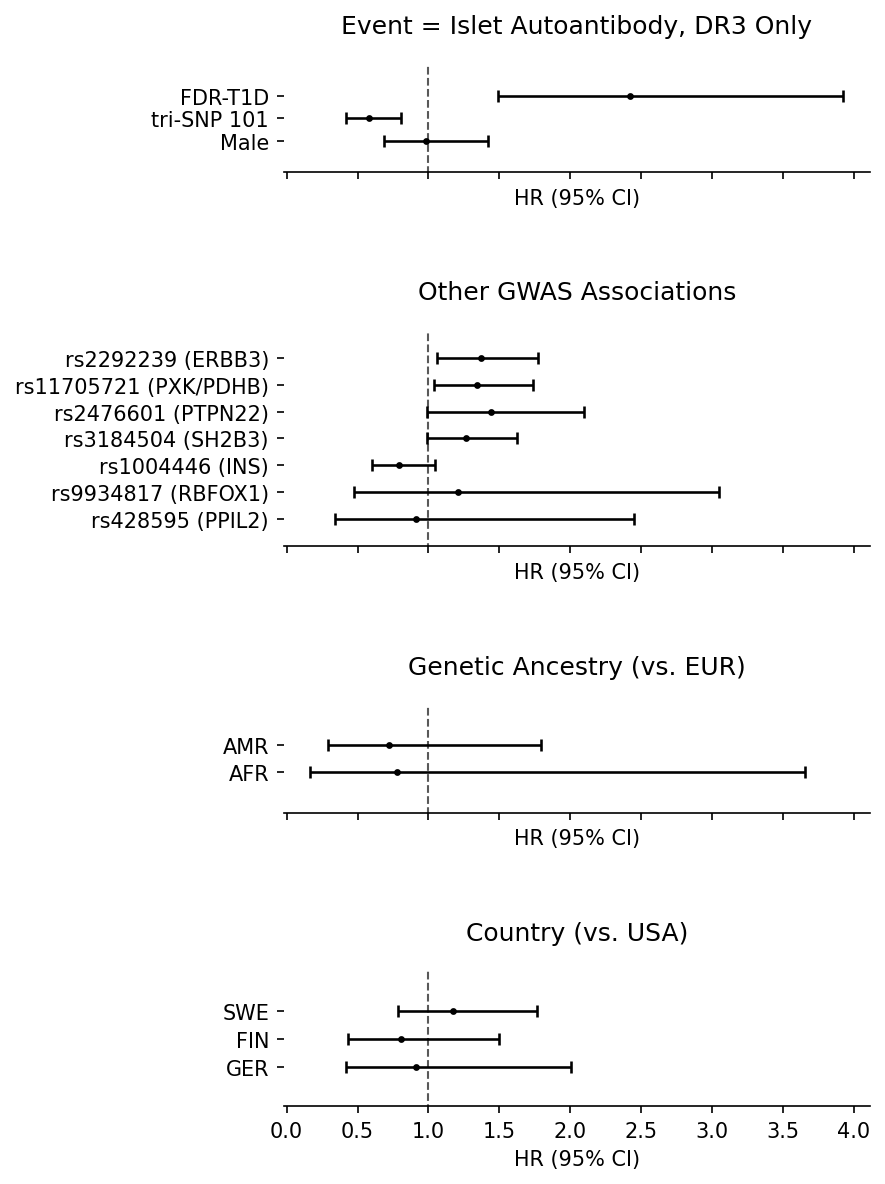

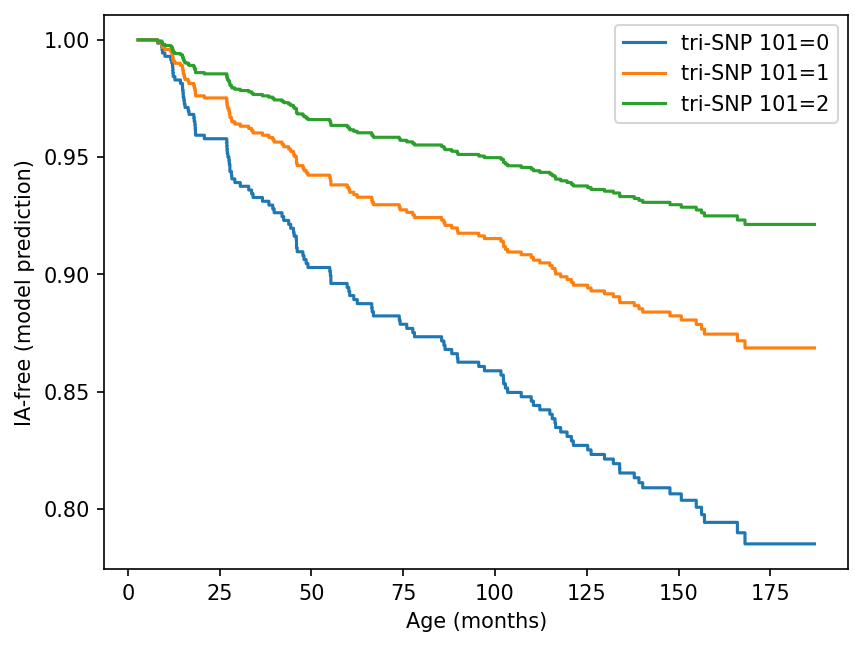

In [13]:
fit_var = "tri-SNP 101"

extension = "cox_ia_dr3_samples"
ylabel = "IA-free (model prediction)"

variables = [fit_var] + common_variables

data = filtered.loc[filtered["hla_type"] == "DR3/DR3",
                    variables + outcomes].dropna()

dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=True, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)

### Fit B8 for DR3 homozygotes only
Change the variable fitted from tri-SNP to DR3-B8. This figure is not used in the paper but the model output is used in the text.

<lifelines.CoxPHFitter: fitted with 1585 total observations, 1464 right-censored observations>
             duration col = 'persist_conf_ab_censor'
                event col = 'persist_conf_ab'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1585
number of events observed = 121
   partial log-likelihood = -827.53
         time fit was run = 2025-09-19 13:51:52 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
B8                     -0.43       0.65       0.12            -0.66            -0.19                 0.51                 0.83
FDR-T1D                 0.88       2.41       0.25             0.40             1.36                 1.49                 3.91
rs428595 (PPIL2)       -0.14       0.87       0.49            -1.10             0.83                 0.33                 2.29
rs1004446 (INS)        -0.22       0.80       0.14            -0.51             0.06                 0.60                 1.06
rs2476601 (PTPN22)      0.39       1.48       0.19             0.01             0.77                 1.01                 2.16
rs2292239 (ERBB3)       0.30       1.35       0.13             0.05             0.56                 1.05                 1.74
rs3184504 (SH2B3)       0.24       1.27       0.13            -0.01             0.49                 0.99                 1.63
rs9934817 (RBFOX1)      0.17       1.18       0.48            -0.77             1.10                 0.46                 3.00
rs11705721 (PXK/PDHB)   0.28       1.32       0.13             0.02             0.54                 1.02                 1.72
Male                    0.00       1.00       0.19            -0.36             0.37                 0.70                 1.44
AMR                    -0.13       0.88       0.46            -1.04             0.78                 0.35                 2.17
AFR                     0.10       1.11       0.74            -1.36             1.56                 0.26                 4.76
SWE                     0.17       1.18       0.20            -0.23             0.57                 0.79                 1.76
FIN                    -0.24       0.78       0.31            -0.86             0.37                 0.43                 1.44
GER                    -0.11       0.90       0.40            -0.89             0.67                 0.41                 1.95

                          z      p   -log2(p)
covariate                                    
B8                    -3.53 <0.005      11.24
FDR-T1D                3.57 <0.005      11.46
rs428595 (PPIL2)      -0.27   0.78       0.35
rs1004446 (INS)       -1.55   0.12       3.06
rs2476601 (PTPN22)     2.03   0.04       4.57
rs2292239 (ERBB3)      2.35   0.02       5.74
rs3184504 (SH2B3)      1.86   0.06       3.98
rs9934817 (RBFOX1)     0.35   0.73       0.46
rs11705721 (PXK/PDHB)  2.11   0.03       4.84
Male                   0.01   0.99       0.02
AMR                   -0.28   0.78       0.36
AFR                    0.14   0.89       0.16
SWE                    0.82   0.41       1.28
FIN                   -0.78   0.43       1.21
GER                   -0.28   0.78       0.36
---
Concordance = 0.67
Partial AIC = 1685.05
log-likelihood ratio test = 48.96 on 15 df
-log2(p) of ll-ratio test = 15.78

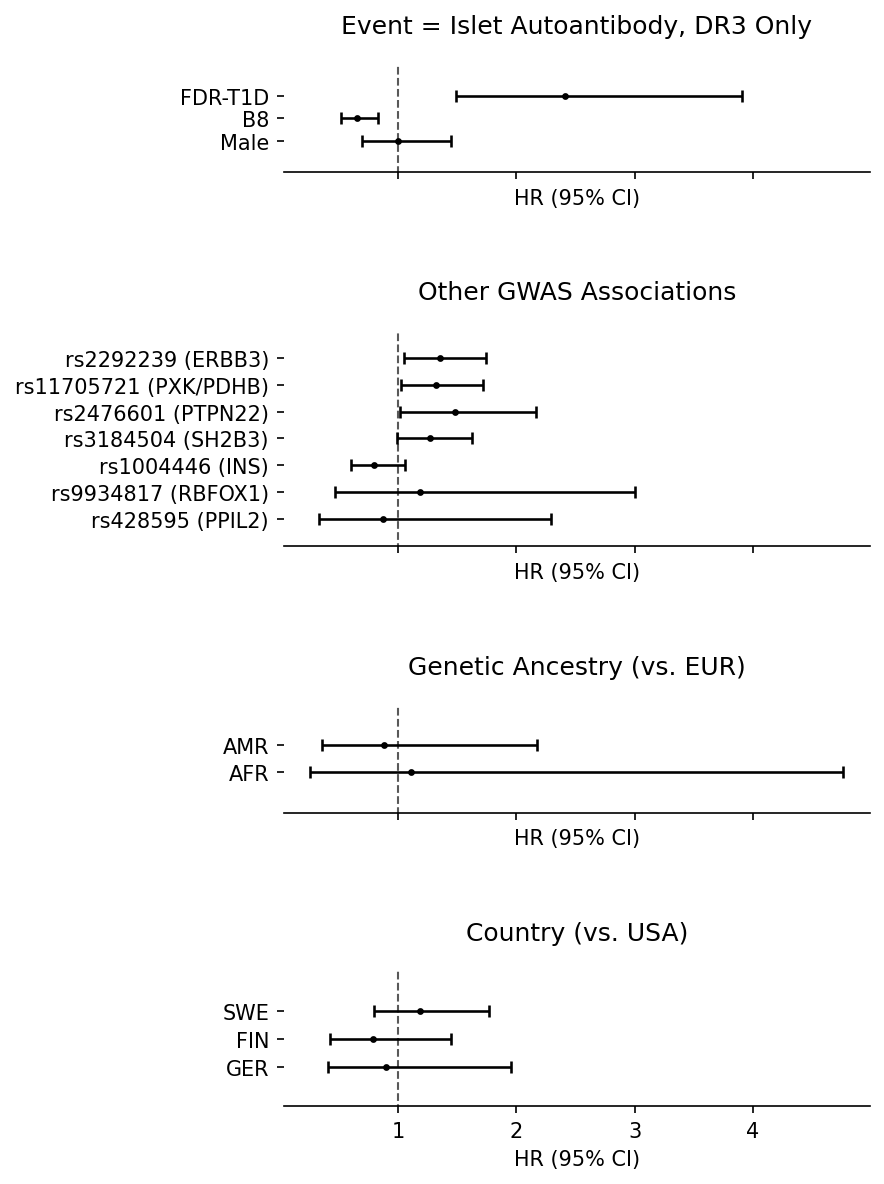

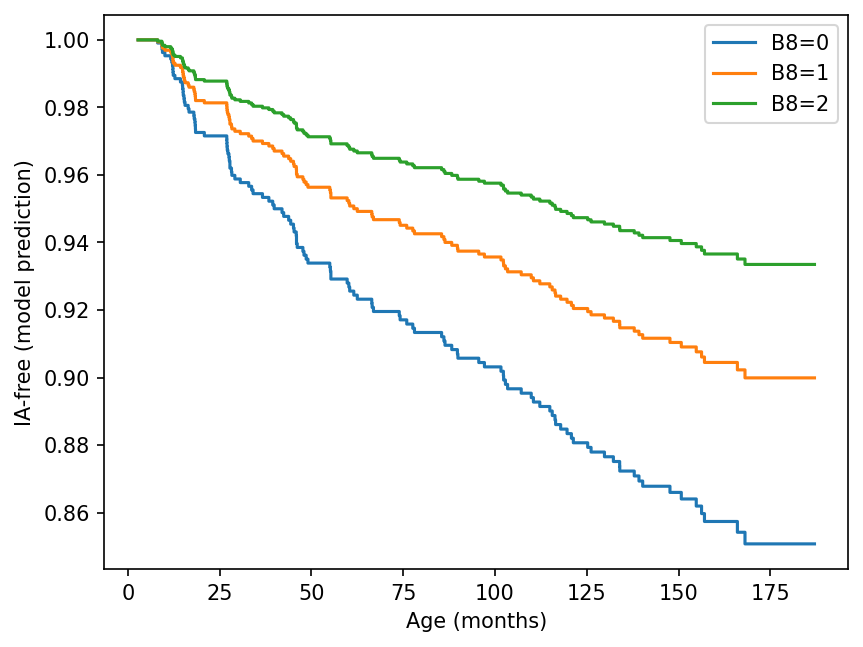

In [14]:
fit_var = "B8"

extension = "cox_ia_dr3_samples_b8"
ylabel = "IA-free (model prediction)"

variables = [fit_var] + common_variables

data = filtered.loc[filtered["hla_type"] == "DR3/DR3",
                    variables + outcomes].dropna()

dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=True, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)